In [2]:
import pandas as pd
import json
import urllib.request
import requests
from datetime import datetime
from datetime import date
from bs4 import BeautifulSoup
import calendar
import re
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
%matplotlib notebook


# <center>Impact of Economic Indicator Releases and Sentiment in Predicting Securities Price Behavior</center>

We will build our preliminary datasets for this project using data from the following pages:

* As unemployment rate is one of the most important economic indicators, this exploratory analysis uses this indicator, but additional indicators will be added as features to the model as they are proven relevant. We retrieved historical data on unemployment rates from the [U.S. Bureau of Labor Statistics](https://data.bls.gov/timeseries/LNU04000000). This data reflects normal revisions in the months following the original announcements and is not seasonally adjusted.  

* Because the historical unemployment data above has been revised after the original announcement, and we are considering the impact of the announcements, we retrieved the original text of the documents released on the first Friday of each month for the last ten years. The links to locations of these documents are found on the [Employment Situation Archived News Releases page](https://www.bls.gov/bls/news-release/empsit.htm).  

* We are using the components of the S&P500 Index as our securities sample for this exploratory analysis. Other securities such as bonds and future contracts can be added later for a more complete picture. Because Standard and Poor doesn't publish an official list of the index constituents, we will be using a dataset from [DataHub](https://datahub.io/core/s-and-p-500-companies/r/constituents.csv) as a relevant and accurate enough unofficial list for sampling purposes.  

* We will be retrieving daily price and volume data for the list of ~500 stocks from [Tiingo](https://www.tiingo.com) using their RESTful API.  

* Finally, we will be extracting historical data from [Twitter](https://twitter.com/home?lang=en) using their full archive API to extract market sentiment data on release dates.  

### Retrieving historical unemployment rates from [U.S. Bureau of Labor Statistics](https://data.bls.gov/timeseries/LNU04000000)  
    Unlike the rest of the data used, these files have been downloaded and converted to csv format for ease of use, and reside in this repository

In [4]:
df_URV=pd.read_csv('LNU04000000_OrigValue.csv', skiprows=12)
df_URC=pd.read_csv('LNU04000000_1MPctChg.csv', skiprows=12)
df_UR_Releases=df_URV.loc[:,['Year','Period','Value']]
df_UR_Releases['Percent Change']=df_URC['Value']
df_UR_Releases.rename(columns={'Value':'Revised Value'},inplace=True)
df_UR_Releases

,Year,Period,Revised Value,Percent Change
0,2010,M01,10.6,9.3
1,2010,M02,10.4,-1.9
2,2010,M03,10.2,-1.9
3,2010,M04,9.5,-6.9
4,2010,M05,9.3,-2.1
...,...,...,...,...
121,2020,M02,3.8,-5.0
122,2020,M03,4.5,18.4
123,2020,M04,14.4,220.0
124,2020,M05,13.0,-9.7


### Retrieving relevant text from original unemployment release documents 
[Employment Situation Archived News Releases page](https://www.bls.gov/bls/news-release/empsit.htm)

In [5]:
release_dates=[]
announcements=[]
linkpage=BeautifulSoup(urllib.request.urlopen('https://www.bls.gov/bls/news-release/empsit.htm').read(), 'html.parser')
pattern=re.compile(r'/news.release/archives/empsit_\d+.htm')
for year in range(2010,2021):
    for month in list(calendar.month_name[1:14]):
        if year==date.today().year and calendar.month_name[date.today().month]==month:
            break
        try:
            search_str=str(month)+' '+str(year)+' '+'Employment Situation'
            line=linkpage.find(text=search_str).parent
            url='https://www.bls.gov'+pattern.search(str(line)).group(0)
            file=str(urllib.request.urlopen(url).read(38000))
            release_dates.append(re.search(r'\d+',url).group(0))
            announcement=re.search(r'rate[,\s]?[\w\s\d\.]+ percent',file).group(0)
            if 'percent.' in announcement or 'Asian' in announcement or 'black' in announcement:
                raise
            announcements.append(announcement)
        except Exception:
            #This method takes longer but is more reliable, so we will save it for when the previous method fails
            file=BeautifulSoup(urllib.request.urlopen(url).read(), 'html.parser').pre.get_text()[400:600].replace('\n','').replace('\r','')
            announcements.append(re.search(r'rate[,\s]?[\w\s\d\.]+ percent',file).group(0))
df_UR_Releases['Release Date']=pd.to_datetime([x[:2]+'/'+x[2:4]+'/'+x[4:] for x in release_dates])
df_UR_Releases['Announcement']=announcements

  #### This is how the text extracted from the releases looks like  
      We will keep it that way as it may be a good indicator of the sentiment of the release, to be analyzed later

In [8]:
df_UR_Releases['Announcement'].head(10)

0         rate fell from 10.0 to 9.7 percent
1                   rate held at 9.7 percent
2                   rate held at 9.7 percent
3               rate edged up to 9.9 percent
4             rate edged down to 9.7 percent
5             rate edged down to 9.5 percent
6          rate was unchanged at 9.5 percent
7    rate was about unchanged at 9.6 percent
8          rate was unchanged at 9.6 percent
9          rate was unchanged at 9.6 percent
Name: Announcement, dtype: object

### Visualizing discrepancies between announced and revised rates

In [9]:
df_UR_Releases['Announced Value']=df_UR_Releases['Announcement'].str.extract(r'(\d+\.\d)( percent$)').loc[:,0].apply(float)
df_UR_Releases['Discrepancy']=df_UR_Releases['Announced Value']-df_UR_Releases['Revised Value']
df_UR_Releases

,Year,Period,Revised Value,Percent Change,Release Date,Announcement,Announced Value,Discrepancy
0,2010,M01,10.6,9.3,2010-02-05,rate fell from 10.0 to 9.7 percent,9.7,-0.9
1,2010,M02,10.4,-1.9,2010-03-05,rate held at 9.7 percent,9.7,-0.7
2,2010,M03,10.2,-1.9,2010-04-02,rate held at 9.7 percent,9.7,-0.5
3,2010,M04,9.5,-6.9,2010-05-07,rate edged up to 9.9 percent,9.9,0.4
4,2010,M05,9.3,-2.1,2010-06-04,rate edged down to 9.7 percent,9.7,0.4
...,...,...,...,...,...,...,...,...
121,2020,M02,3.8,-5.0,2020-03-06,rate was little changed at 3.5 percent,3.5,-0.3
122,2020,M03,4.5,18.4,2020-04-03,rate rose to 4.4 percent,4.4,-0.1
123,2020,M04,14.4,220.0,2020-05-08,rate rose to 14.7 percent,14.7,0.3
124,2020,M05,13.0,-9.7,2020-06-05,rate declined by 1.4 percentage points to 13.3...,13.3,0.3


<IPython.core.display.Javascript object>


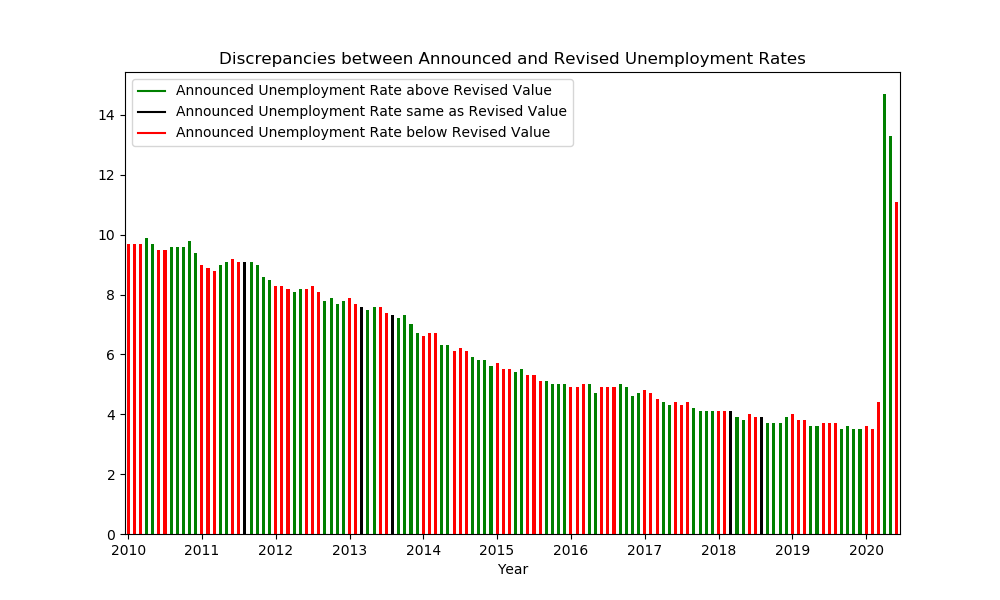

In [10]:
fig=plt.figure(figsize=(10,6))
ax=plt.gca(title='Discrepancies between Announced and Revised Unemployment Rates')
colors=['green' if x>0 else 'black' if x==0 else 'red' for x in df_UR_Releases['Discrepancy']]
df_UR_Releases.plot(kind='bar', x='Year', y='Announced Value', color=colors, label=None, ax=ax)
df_UR_Releases.plot(kind='line', x='Year', y='Announced Value', color='green', label=None, ax=ax)
df_UR_Releases.plot(kind='line', x='Year', y='Announced Value', color='black', label=None, ax=ax)
df_UR_Releases.plot(kind='line', x='Year', y='Announced Value', color='red', label=None, ax=ax)
ax.set_xticks(ax.get_xticks()[::12])
ax.set_xticklabels([str(x) for x in range(2010,2021)])
plt.xticks(rotation=0)
handles, labels = ax.get_legend_handles_labels()
labels[0]='Announced Unemployment Rate above Revised Value'
labels[1]='Announced Unemployment Rate same as Revised Value'
labels[2]='Announced Unemployment Rate below Revised Value'
labels=labels[:3]
ax.legend(handles, labels)

### Retrieving historical stock prices

#### Retrieving S&P 500 tickers from [DataHub](https://datahub.io/core/s-and-p-500-companies/r/constituents.csv)

In [11]:
df_SP500=pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')
tickers=list(df_SP500['Symbol'])
tickers[0]='SPY'
tickers

['SPY',
 'AOS',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AAP',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'CXO',
 'COP',
 'ED'

#### Using [Tiingo](https://www.tiingo.com) RESTful API to retrieve 10 year daily historical data for stocks in sample

In [12]:
def get_EOD_data(symbol,sdate,edate):
    
    base_url='https://api.tiingo.com/tiingo/daily/'+symbol+'/prices?'
    api_key='9fa4df1e30e2fb224f1a625b7c43867b1880d05f'
    parameters={
        'token':api_key,
        'startDate':sdate,
        'endDate': edate,
    }
    response = requests.get(base_url, params=parameters)
    return response
d_all_EOD={}

for n,ticker in enumerate(tickers):
    try:
        df_EOD=pd.DataFrame(get_EOD_data(ticker,'2010-1-1','2020-7-20').json())
        df_EOD['date']=df_EOD['date'].apply(lambda x:x[:10]).apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
        d_all_EOD[ticker]=df_EOD
    except Exception as err:
        print('{} Error retrieving data for {}.'.format(err,ticker))

If using all scalar values, you must pass an index Error retrieving data for BRK.B.
Expecting value: line 1 column 1 (char 0) Error retrieving data for BIO.
If using all scalar values, you must pass an index Error retrieving data for BF.B.
Expecting value: line 1 column 1 (char 0) Error retrieving data for TDY.
Expecting value: line 1 column 1 (char 0) Error retrieving data for TYL.
If using all scalar values, you must pass an index Error retrieving data for YUM.
If using all scalar values, you must pass an index Error retrieving data for ZBRA.
If using all scalar values, you must pass an index Error retrieving data for ZBH.
If using all scalar values, you must pass an index Error retrieving data for ZION.
If using all scalar values, you must pass an index Error retrieving data for ZTS.


In [8]:
d_all_EOD

{'SPY':            date   close    high     low    open     volume    adjClose  \
 0    2010-01-04  113.33  113.39  111.51  112.37  118857369   91.796474   
 1    2010-01-05  113.63  113.68  112.85  113.26  111519230   92.039472   
 2    2010-01-06  113.71  113.99  113.43  113.52  116017127   92.104271   
 3    2010-01-07  114.19  114.33  113.18  113.50  130502017   92.493068   
 4    2010-01-08  114.57  114.62  113.66  113.89  126357911   92.800865   
 ...         ...     ...     ...     ...     ...        ...         ...   
 2649 2020-07-14  318.92  319.76  312.00  313.30   92791800  318.920000   
 2650 2020-07-15  321.85  323.04  319.27  322.41   86921500  321.850000   
 2651 2020-07-16  320.79  321.28  319.09  319.79   54433400  320.790000   
 2652 2020-07-17  321.72  322.57  319.74  321.88   64421800  321.720000   
 2653 2020-07-20  324.32  325.13  320.62  321.43   56150200  324.320000   
 
          adjHigh      adjLow     adjOpen  adjVolume  divCash  splitFactor  
 0      91.845

### Documenting changes in price in response to announcements

In [14]:
df_changes=pd.DataFrame(index=d_all_EOD.keys(),columns=df_UR_Releases['Release Date'])
for ticker in d_all_EOD.keys():
    #for date in df_UR_Releases['Release Date']:
    for date in df_changes:
        try:
            row=d_all_EOD[ticker][d_all_EOD[ticker]['date']==date]
            index=int(row.index[0])      
        except Exception:
            #Keep trying dates for tickers that start at a later date than our chosen January 2010
            if d_all_EOD[ticker]['date'].iloc[0]>date:
                continue
            #Sometimes the market is closed on the Friday when Unemployment Rates are announced, so we skip to Monday
            try:
                row=d_all_EOD[ticker][d_all_EOD[ticker]['date']==date+timedelta(days=3)]
                index=int(row.index[0])
            except Exception as err:
                print('Error {} date not found for {} on date {}'.format(err,ticker,date))
                continue
        close=row.iloc[0]['close'] 
        prev_close=d_all_EOD[ticker].iloc[index-1]['close']
        change=((close-prev_close)/prev_close)*100
        df_changes.loc[ticker,date]=change

Error index 0 is out of bounds for axis 0 with size 0 date not found for LIN on date 2018-10-05 00:00:00


In [15]:
df_changes

Release Date,2010-02-05,2010-03-05,2010-04-02,2010-05-07,2010-06-04,2010-07-02,2010-08-06,2010-09-03,2010-10-08,2010-11-05,...,2019-10-04,2019-11-01,2019-12-06,2020-01-10,2020-02-07,2020-03-06,2020-04-03,2020-05-08,2020-06-05,2020-07-02
SPY,0.206689,1.42933,0.814941,-1.48926,-3.51368,-0.544959,-0.407621,1.29716,0.560877,0.376247,...,1.35321,0.926384,0.913403,-0.28777,-0.532966,-1.65311,-1.44542,1.65462,2.56295,0.550689
AOS,0.554752,0.780426,2.32292,-3.78879,-3.06489,0.560515,-0.621005,2.03466,0.694444,-0.0501588,...,1.13333,1.20773,-0.234542,1.21148,-3.0254,2.54624,-0.194769,3.41722,2.82776,2.20302
ABT,0.278707,0.443787,-0.0566465,-0.571429,-2.51414,0,1.18047,0.256866,0.437429,0.0786164,...,1.13482,-1.13623,0.281558,-1.24942,-1.78831,1.51515,0.0125881,-0.308543,1.82436,0.643824
ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.09682,2.76556,0.299815,-1.2748,5.86144,-1.9755,-2.34261,-0.308715,0.870593,-0.262255
ABMD,1.9347,1.50659,1.5,-3.58343,-4.78564,-1.12474,-2.72904,1.25786,-0.552486,-0.0841751,...,1.3291,4.43684,0.0793357,2.97386,-4.64262,1.66332,-1.31212,-0.669038,5.84273,3.37748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYNN,0.871137,2.80771,6.30491,-4.43203,-5.16873,-1.76015,1.33983,3.70852,5.13639,0.488802,...,-0.864737,1.52464,2.88323,0.604995,-5.42514,-1.62168,-7.91722,9.22111,6.53177,4.78385
XEL,-0.494315,0.617284,1.07477,-1.1369,-2.55915,0.436469,0.271985,0.484795,0.170721,0.870647,...,1.83566,-0.645568,-0.225298,0.159898,-0.851371,1.29964,-4.23701,0.583722,0.353683,-0.140209
XRX,-2.08092,3.45912,3.9039,-3.08765,-4.20712,0.250941,-0.518672,1.79171,1.95531,-0.251467,...,0.886464,-1.32626,-0.132205,0.136612,-1.3535,-1.16867,-8.54978,4.61627,4.41176,3.82838
XLNX,1.46048,1.8688,2.57009,-1.13269,-1.11926,-0.82224,0.143524,0.833995,0.578481,-0.43088,...,1.8921,2.17104,1.31245,-2.00965,-2.39398,-1.48038,-0.0884397,2.87812,0.543478,2.16576


#### Analyzing biggest gainers

In [16]:
maxval_ticker=df_changes.max(axis=1).idxmax()
maxval_date=df_changes.max(axis=0).idxmax()
maxval=df_changes.max().max()
maxval_ticker,maxval_date,maxval

('OXY', Timestamp('2020-06-05 00:00:00'), 33.697749196141466)

In [17]:
df_changes.loc[maxval_ticker].sort_values(ascending=False)

Release Date
2020-06-05    33.6977
2020-05-08    8.21326
2019-11-01    4.41975
2015-10-02    4.27467
2012-02-03    4.21405
               ...   
2015-03-06   -3.51013
2019-08-02   -3.74271
2019-03-08   -4.60907
2010-06-04   -5.42692
2020-03-06    -14.676
Name: OXY, Length: 126, dtype: object

In [18]:
df_changes[datetime(2020,6,5)].sort_values(ascending=False).head(50)

OXY      33.6977
APA      23.6154
RCL      20.3675
MRO       17.496
CCL      16.3961
SPG      15.4698
DVN      14.7799
NCLH     14.4972
F        11.7199
KSS      11.4933
BA        11.465
OKE      11.3977
FTI      11.3821
AAL      11.1842
NBL      11.0454
ALGN     10.8202
HWM      10.4958
HAL      10.0834
PVH      9.83721
FLT      9.76254
FANG     9.50084
MPC      9.25342
NOV      9.22965
CXO      9.20255
IVZ      8.89121
PAYC     8.77725
ALLE     8.72844
AVB      8.69894
COP      8.67815
HES      8.66997
LNC      8.66667
UAL      8.45269
IR        8.3442
LW       8.26622
HBI      8.20771
SLB      8.16527
XOM      8.10591
HCA      8.04039
PAYX     7.89864
GLW      7.79798
EQR      7.68732
UDR      7.64068
KEY      7.61271
EOG      7.54306
CDW       7.3576
DISCA    7.31919
HST      7.27412
CBRE     7.16128
DVA      7.14893
DISCK    7.14286
Name: 2020-06-05 00:00:00, dtype: object

#### Analyzing biggest loosers

In [19]:
minval_ticker=df_changes.min(axis=1).idxmin()
minval_date=df_changes.min(axis=0).idxmin()
minval=df_changes.min().min()
minval_ticker,minval_date,minval

('ICE', Timestamp('2016-11-04 00:00:00'), -80.19445578357517)

In [20]:
df_changes.loc['ICE'].sort_values()

Release Date
2016-11-04   -80.1945
2010-07-02   -5.68232
2016-02-05   -4.02292
2020-03-06   -3.95261
2017-11-03   -3.53866
               ...   
2019-10-04    2.90093
2010-02-05    3.03443
2011-05-06    3.10363
2013-06-07    3.25059
2015-12-04    4.05767
Name: ICE, Length: 126, dtype: object

In [21]:
df_changes[datetime(2016,11,4)].sort_values().head(50)

ICE    -80.1945
QRVO   -9.97533
NLOK   -7.70138
NTAP   -6.16333
WLTW   -5.57128
TSN    -3.98742
ATVI   -3.85059
MNST   -3.55182
J      -3.48814
MRO    -3.25088
ABC    -2.55808
KHC    -2.55072
CPRT   -2.42075
BLL    -2.24949
LNC    -2.12186
AMD    -2.08955
AWK    -2.08073
COTY   -2.05817
ALL    -2.01204
COP    -1.92661
XRX    -1.92513
AAP    -1.91574
CXO    -1.82889
SBAC   -1.80656
PG      -1.7552
INFO   -1.74226
XLNX   -1.69659
WFC    -1.63211
MDLZ   -1.61625
MKC    -1.59182
AMZN   -1.56187
COST   -1.52994
NOV    -1.51375
UNM    -1.51348
FFIV   -1.50932
ULTA   -1.48526
HES    -1.42281
LDOS   -1.41924
CL     -1.41703
HII    -1.33791
AIG    -1.32416
OXY    -1.27502
WELL   -1.27311
CLX    -1.27266
DOV    -1.25075
FTI    -1.22549
HIG    -1.21143
PXD    -1.18958
KMB    -1.14386
CMG    -1.14222
Name: 2016-11-04 00:00:00, dtype: object

### Visualizing big movers

#### Highest average movement

In [22]:
df_changes['means']=abs(df_changes).mean(axis=1)
big_movers=df_changes[df_changes['means']>2]
big_movers['means']

AMD      2.161139
AAL      2.033704
APA      2.191474
ANET     4.259027
CARR    11.124888
CF       2.063708
DXCM     2.121654
FANG     2.404597
DD       2.487107
DXC      2.152082
FCX      2.226624
HPE      2.460800
ILMN     2.073489
INCY     2.272442
IPGP     2.118544
MRO      2.197345
OTIS     4.189652
QRVO     2.523478
SWKS     2.226429
FTI      2.130724
TWTR     2.051407
URI      2.122310
WYNN     2.093618
Name: means, dtype: float64

#### Preparing dataset to plot

In [23]:
df_toplot=pd.DataFrame(columns=['ticker','value'])
for ticker in big_movers.index:
    df_temp=pd.DataFrame(columns=['ticker','value'])
    df_temp['value']=big_movers.loc[ticker].drop('means')
    df_temp['ticker']=ticker
    df_toplot=pd.concat([df_toplot,df_temp])
df_toplot=df_toplot.dropna().astype({'value':'float64'})

<IPython.core.display.Javascript object>


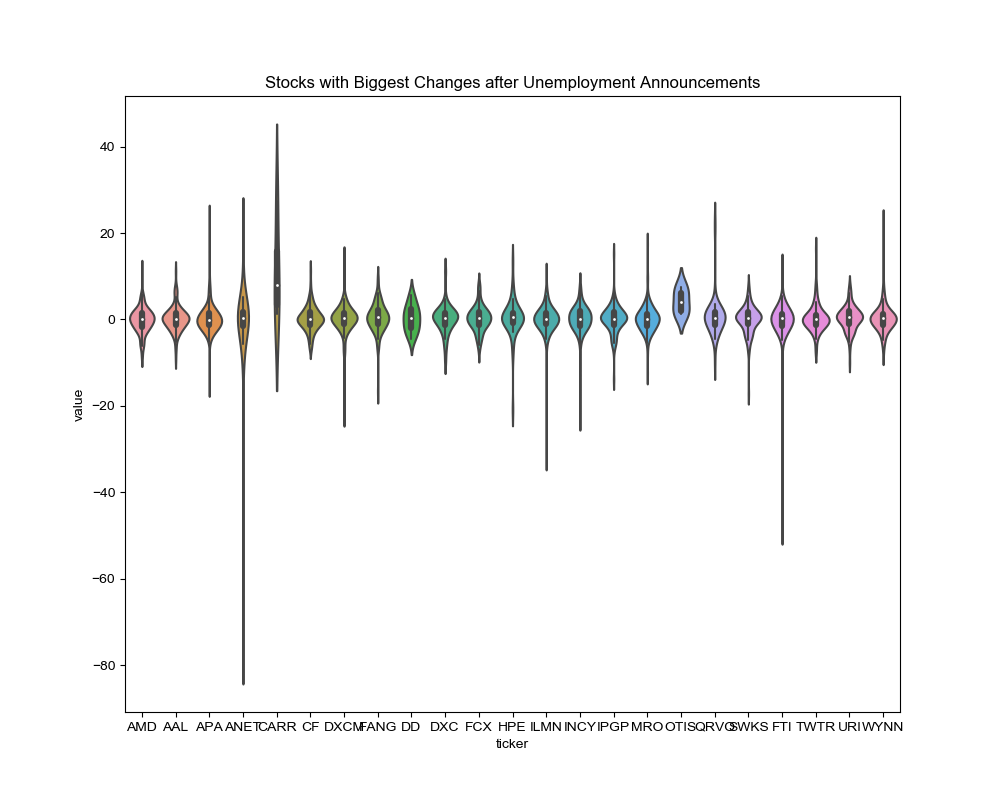

In [24]:
plt.figure(figsize=(10,8))
ax=plt.gca()
plt.title('Stocks with Biggest Changes after Unemployment Announcements')
plt.style.use('seaborn-whitegrid')
sns.violinplot('ticker', 'value', data=df_toplot, colormap='viridis', ax=ax);

### Retrieving historical data from [Twitter](https://twitter.com/home?lang=en)

In [25]:
import searchtweets
from searchtweets import ResultStream, gen_rule_payload, load_credentials

premium_search_args = load_credentials("twitter_keys.yaml",
                                       yaml_key=" search_tweets_fullarchive_dev",env_overwrite=False)
rule = gen_rule_payload("MSFT", results_per_call=10)
rule

cannot read file twitter_keys.yaml
Error parsing YAML file; searching for valid environment variables
Account type is not specified and cannot be inferred.
        Please check your credential file, arguments, or environment variables
        for issues. The account type must be 'premium' or 'enterprise'.
        


KeyError: 